# Import packages

In [1]:
from typing import Dict, Union

# model_general
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.data import Data
from torch_cluster import radius_graph
from torch_scatter import scatter
import torch_scatter

# e3nn
import e3nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import FullyConnectedNet, Gate

# from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from e3nn.util.jit import compile_mode

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from ase import io

# other
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import math
import time
from tqdm import tqdm
import numpy as np

bar_format = "{l_bar}{bar:10}{r_bar}{bar:-10b}"
textsize = 14
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Import data

In [2]:
from _GraphNW import PeriodicNetwork, Network
import _Convolution
from _Training import train, evaluate
from Data_processing import data_processing, get_neighbors, transform_data
from Split_dat import split

100%|██████████| 118/118 [00:00<00:00, 283139.51it/s]


# Create Model

In [3]:
r_max = 4
data, y_m, y_std = data_processing("input.xyz", r_max)

In [4]:
d_load_train, d_load_val, d_load_test = split(data, train_size=0.8, valid_size=0.1, test_size=0.1)
d_load_train

In [5]:
n_train = get_neighbors(d_load_train.dataset)

## Device agnostic setting

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print("torch device:", device)

torch device: cuda


## Model

In [7]:
out_dim = 1
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,  # dimension of one-hot encoding of atom type
    em_dim=em_dim,  # dimension of atom-type embedding
    irreps_in=str(em_dim) + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim) + "x0e",  # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim) + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=3,  # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,  # multiplicity of irreducible representations
    lmax=1,  # maximum order of spherical harmonics
    max_radius=r_max,  # cutoff radius for convolution
    num_neighbors=n_train.mean(),  # num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    # reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print("MODEL ------------------------------------------------------------------")
print(model)
print("")

print("MODEL DEVICE -----------------------------------------------------------")
print(next(model.parameters()).device)
print("")

MODEL ------------------------------------------------------------------
PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): Linear(64x0e -> 64x0e | 4096 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): Linear(64x0e+64x1o -> 64x0e+32x1o | 6144 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): Linear(32x0e+32x1o -> 32x0e+32x1o | 2048 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+32x1e | 160 paths | 160 weights)
        (lin2): Linear(64x0e+64x

## Visualize Crystal

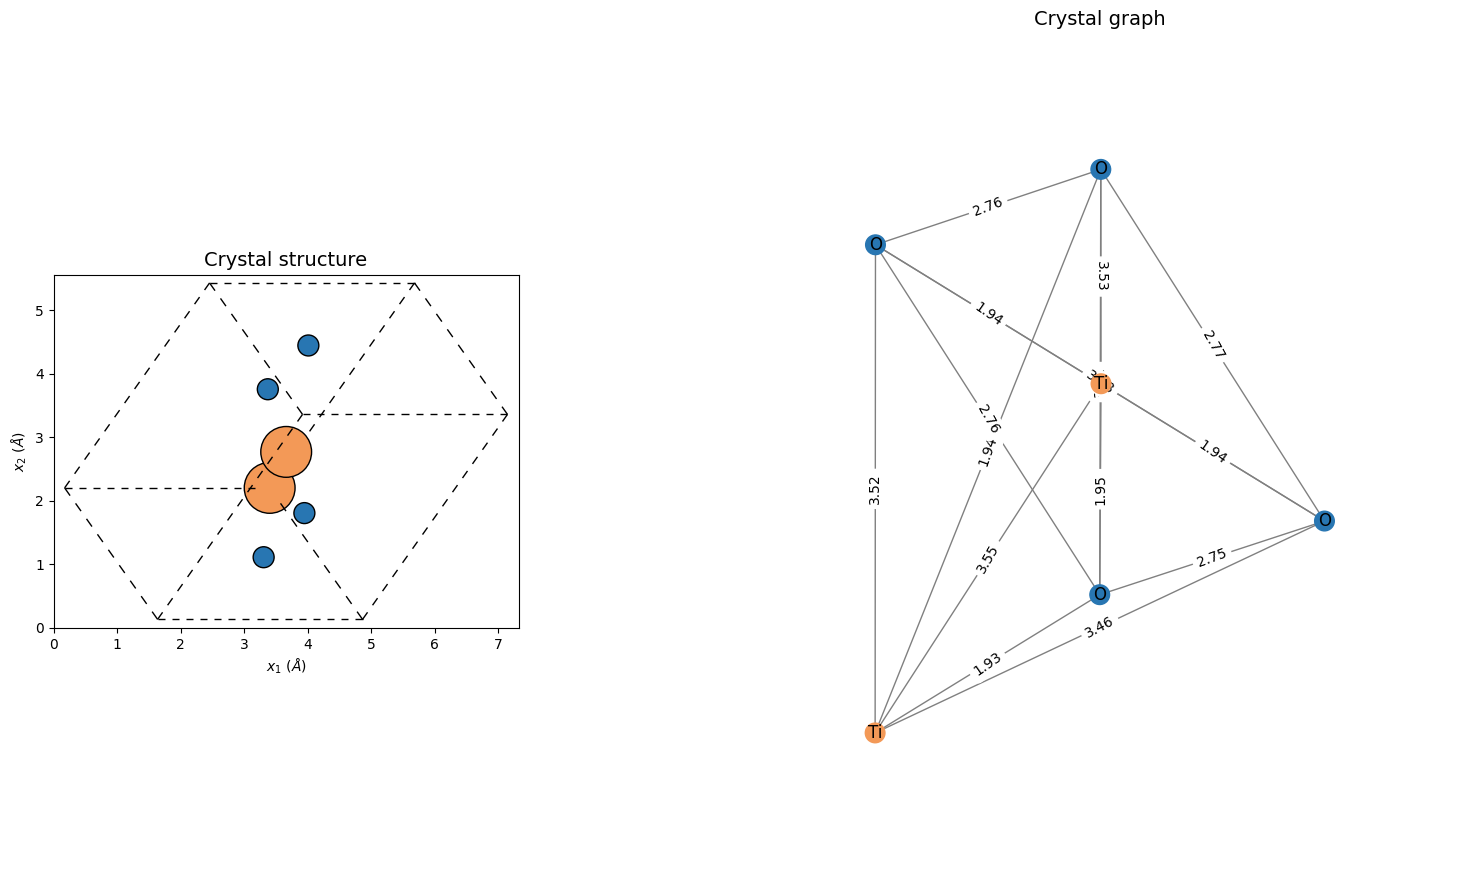

In [8]:
palette = ["#2876B2", "#F39957", "#67C7C2", "#C86646"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("cmap", [palette[k] for k in [0, 2, 1]])
fontsize = 14


def plot_example(df, i=0, label_edges=False):
    # plot an example crystal structure and graph
    entry = df[i]

    # get graph with node and edge attributes
    g = tg.utils.to_networkx(entry, node_attrs=["symbol"], edge_attrs=["edge_len"], to_undirected=True)

    # remove self-loop edges for plotting
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    node_labels = dict(zip([k[0] for k in g.nodes.data()], [k[1]["symbol"] for k in g.nodes.data()]))
    edge_labels = dict(zip([(k[0], k[1]) for k in g.edges.data()], [k[2]["edge_len"] for k in g.edges.data()]))

    # project positions of nodes to 2D for plotting
    pos = dict(zip(list(g.nodes), [np.roll(k, 2)[:-1][::-1] for k in entry.pos.numpy()]))

    # plot unit cell
    fig, ax = plt.subplots(1, 2, figsize=(18, 14), gridspec_kw={"width_ratios": [2, 3]})
    atoms = Atoms(symbols=entry.symbol, positions=entry.pos.numpy(), cell=entry.lattice.squeeze().numpy(), pbc=True)
    symbols = np.unique(entry.symbol)
    z = dict(zip(symbols, range(len(symbols))))
    norm = plt.Normalize(vmin=0, vmax=len(symbols) - 1)
    color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in entry.symbol]))]
    plot_atoms(atoms, ax[0], radii=0.25, colors=color, rotation=("45x,45y,0z"))

    # plot graph
    nx.draw_networkx(g, ax=ax[1], labels=node_labels, pos=pos, node_size=200, node_color=color, edge_color="gray")

    if label_edges:
        nx.draw_networkx_edge_labels(g, ax=ax[1], edge_labels=edge_labels, pos=pos, label_pos=0.5)

    # format axes
    ax[0].set_xlabel(r"$x_1\ (\AA)$")
    ax[0].set_ylabel(r"$x_2\ (\AA)$")
    ax[0].set_title("Crystal structure", fontsize=fontsize)
    ax[1].set_aspect("equal")
    ax[1].axis("off")
    ax[1].set_title("Crystal graph", fontsize=fontsize)
    pad = np.array([-0.5, 0.5])
    ax[1].set_xlim(np.array(ax[1].get_xlim()) + pad)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) + pad)
    fig.subplots_adjust(wspace=0.4)


plot_example(data, 0, label_edges=True)

## Optimizer and Loss function

In [9]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

## Run settings

In [10]:
# run_name = "model_0" + time.strftime("%y%m%d", time.localtime())
run_name = "model_0"
print(run_name)

model_0


In [11]:
from pathlib import Path

if Path("MODEL.pth").exists():
    model.load_state_dict(torch.load("MODEL.pth"))

else:
    train(
        model,
        opt,
        d_load_train,
        d_load_val,
        loss_fn,
        loss_fn_mae,
        run_name,
        max_iter=1,
        scheduler=scheduler,
        device=device,
    )
    torch.save(model.state_dict(), "MODEL.pth")

/tmp/ipykernel_52747/145318161.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("MODEL.pth"))


/tmp/ipykernel_52747/1774169381.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(run_name + ".torch", map_location=device)["history"]


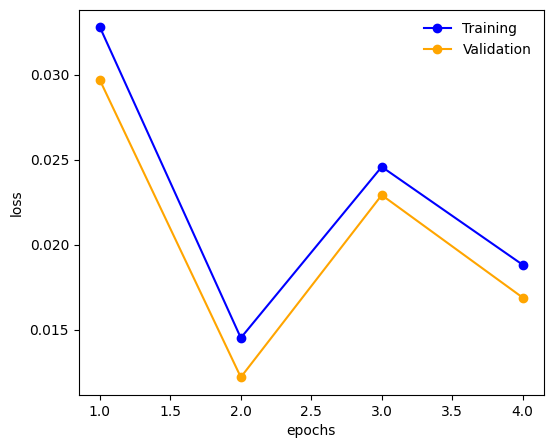

In [12]:
run_name = "model_241031"

history = torch.load(run_name + ".torch", map_location=device)["history"]
steps = [d["step"] + 1 for d in history]
loss_train = [d["train"]["loss"] for d in history]
loss_valid = [d["valid"]["loss"] for d in history]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(steps, loss_train, "o-", label="Training", color="blue")
ax.plot(steps, loss_valid, "o-", label="Validation", color="orange")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(frameon=False)

In [13]:
d = data[1].clone()
d.pos.device

device(type='cpu')

In [14]:
model.to("cpu")
_d1 = data[1].clone()
print("POS 1", _d1.pos)
_out1 = model(_d1)
print("OUT 1", _out1)

POS 1 tensor([[2.2822, 2.2835, 1.4572],
        [4.5595, 4.5614, 0.0095],
        [0.8906, 3.6724, 1.4587],
        [3.6638, 0.8974, 1.4684],
        [1.3830, 1.3834, 2.9245],
        [3.1797, 3.1864, 0.0089]])
OUT 1 (tensor([-1.0936], grad_fn=<SumBackward1>), tensor([[-0.0765],
        [-0.0111],
        [-0.2411],
        [-0.2356],
        [-0.2653],
        [-0.2640]], grad_fn=<ViewBackward0>))


In [15]:
_d2 = data[1].clone()
newpos = _d2.pos + 0.5 * torch.randn_like(_d2.pos)
nd2 = transform_data(_d2, newpos)
print("POS 2: \n", nd2.pos)
_out2 = model(nd2)
print("OUT 2: \n", _out2)

POS 2: 
 tensor([[1.7313, 2.5568, 2.3273],
        [3.8786, 4.1627, 0.9512],
        [0.6246, 3.7182, 0.9642],
        [4.5913, 1.3576, 1.9094],
        [0.9369, 0.9746, 3.1459],
        [2.7953, 3.2929, 0.0356]])
OUT 2: 
 (tensor([4.1936], grad_fn=<SumBackward1>), tensor([[0.6622],
        [0.5639],
        [0.8290],
        [0.4711],
        [1.4386],
        [0.2287]], grad_fn=<ViewBackward0>))


In [16]:
def force(data):

    def wrapper(pos: torch.Tensor) -> torch.Tensor:

        _data = data.clone()
        ndata = transform_data(_data, pos)
        out, _ = model(ndata)  # total energy, energy per atom
        print("Printing Positions: -------------------")
        print(pos)
        return out  # .squeeze(-1)

    pos = data.pos
    pos.requires_grad = True

    f = torch.autograd.functional.jacobian(
        func=wrapper,
        inputs=pos,
        create_graph=True,  # needed to allow gradients of this output during training
        strict=True,
        # vectorize=self.vectorize,
    )
    # print(pos)
    print("Printing Forces: -------------------")
    print(f)
    return f

In [17]:
d = data[1].clone()
f = force(d)

Printing Positions: -------------------
tensor([[2.2822, 2.2835, 1.4572],
        [4.5595, 4.5614, 0.0095],
        [0.8906, 3.6724, 1.4587],
        [3.6638, 0.8974, 1.4684],
        [1.3830, 1.3834, 2.9245],
        [3.1797, 3.1864, 0.0089]], grad_fn=<ViewBackward0>)


RuntimeError: Output 0 of the user-provided function is independent of input 0. This is not allowed in strict mode.

In [ ]:
import torch
import ase
from ase import Atoms
from ase.calculators.emt import EMT  # Use EMT as an example potential (can replace with other calculators)
from torch.autograd.functional import jacobian
from copy import deepcopy

# Step 1: Set up the atomic system in ASE
atoms = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.8]])  # A simple H2 molecule
atoms.calc = EMT()  # Set a calculator for the energy (using EMT here as an example)


# Step 2: Define the energy function
def energy_function(positions):
    """
    Compute the energy of the system given atomic positions.
    :param positions: Flattened tensor of atomic positions [x1, y1, z1, x2, y2, z2, ...]
    :return: Scalar tensor of energy
    """
    # Reshape positions to match the shape required by ASE (N_atoms, 3)
    pos = deepcopy(positions).view(-1, 3).detach().numpy()

    # Set positions in ASE atoms object
    atoms.set_positions(pos)

    # Calculate the potential energy using ASE
    energy = atoms.get_potential_energy()

    # Return energy as a PyTorch tensor
    return torch.tensor(energy, requires_grad=True)


# Step 3: Compute forces using Jacobian of the energy
# Convert initial ASE positions to a flattened PyTorch tensor
initial_positions = torch.tensor(atoms.get_positions().flatten(), requires_grad=True)

# Compute the Jacobian of the energy with respect to positions
jacobian_matrix = jacobian(energy_function, initial_positions)

# Forces are the negative of the gradient (Jacobian) of the energy with respect to positions
forces = -jacobian_matrix

# Reshape forces to (N_atoms, 3) for readability
forces = forces.view(-1, 3)

# Print results
print("Atomic Positions:\n", atoms.get_positions())
print("Forces:\n", forces)  # .detach().numpy())

print("Real Forces:")
print(atoms.get_forces())

<class 'torch.Tensor'>
Atomic Positions:
 [[0.  0.  0. ]
 [0.  0.  0.8]]
Forces:
 tensor([[-0., -0., -0.],
        [-0., -0., -0.]])
Real Forces:
[[ 0.          0.          1.72676879]
 [ 0.          0.         -1.72676879]]


In [31]:
import torch
import ase
from ase import Atoms
from ase.calculators.emt import EMT
from torch.autograd.functional import hessian

# Step 1: Set up the atomic system in ASE
atoms = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.74]])  # Simple H2 molecule
atoms.set_calculator(EMT())  # Using EMT as an example potential


# Step 2: Define the energy function
def energy_function(positions):
    """
    Compute the energy of the system given atomic positions.
    :param positions: Flattened tensor of atomic positions [x1, y1, z1, x2, y2, z2, ...]
    :return: Scalar tensor of energy
    """
    # Reshape positions to match the shape required by ASE (N_atoms, 3)
    pos = positions.view(-1, 3)  # Don't detach here to keep gradients
    pos_np = pos.detach().numpy()  # Convert to NumPy for ASE compatibility

    # Set positions in ASE atoms object
    atoms.set_positions(pos_np)

    # Calculate the potential energy using ASE
    energy = atoms.get_potential_energy()

    # Return energy as a PyTorch tensor
    return torch.tensor(energy, requires_grad=True)


# Step 3: Calculate the Hessian of the energy with respect to positions
# Convert initial ASE positions to a flattened PyTorch tensor
initial_positions = torch.tensor(atoms.get_positions().flatten(), requires_grad=True)

# Compute the Hessian matrix
hessian_matrix = hessian(energy_function, initial_positions)

# Step 4: Reshape and Interpret the Hessian
# The Hessian is of shape (3N, 3N), where each (i, j) entry is the second derivative of E w.r.t. position coordinates.
# Reshape Hessian to (N_atoms, 3, N_atoms, 3) to see the interactions in blocks
N_atoms = len(atoms)
hessian_matrix = hessian_matrix.view(N_atoms, 3, N_atoms, 3)

# Print the Hessian matrix for interpretation
print("Hessian Matrix:\n", hessian_matrix)

Hessian Matrix:
 tensor([[[[0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.]]]])


/tmp/ipykernel_52747/2869295200.py:9: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(EMT())  # Using EMT as an example potential


In [32]:
import numpy as np
from ase import Atoms
from ase.calculators.emt import EMT

# Parameters for finite difference
delta = 1e-4  # Small displacement for finite difference

# Step 1: Set up the atomic system in ASE
atoms = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.74]])  # Simple H2 molecule
atoms.set_calculator(EMT())  # Using EMT as an example potential


# Step 2: Define a function to calculate the energy given a set of atomic positions
def calculate_energy(atoms, positions):
    atoms.set_positions(positions)
    return atoms.get_potential_energy()


# Step 3: Initialize the Hessian matrix
num_atoms = len(atoms)
num_coordinates = num_atoms * 3  # Total number of coordinates (x, y, z for each atom)
hessian_matrix = np.zeros((num_coordinates, num_coordinates))

# Get initial positions as a flattened array
initial_positions = atoms.get_positions().flatten()

# Step 4: Compute the Hessian matrix using finite differences
for i in range(num_coordinates):
    for j in range(i, num_coordinates):  # Only compute upper triangle (symmetry)

        # Initialize perturbed positions
        pos_pp = initial_positions.copy()  # +delta in both i and j
        pos_pm = initial_positions.copy()  # +delta in i, -delta in j
        pos_mp = initial_positions.copy()  # -delta in i, +delta in j
        pos_mm = initial_positions.copy()  # -delta in both i and j

        # Apply perturbations
        pos_pp[i] += delta
        pos_pp[j] += delta
        pos_pm[i] += delta
        pos_pm[j] -= delta
        pos_mp[i] -= delta
        pos_mp[j] += delta
        pos_mm[i] -= delta
        pos_mm[j] -= delta

        # Calculate energies for each perturbed position
        energy_pp = calculate_energy(atoms, pos_pp.reshape(-1, 3))
        energy_pm = calculate_energy(atoms, pos_pm.reshape(-1, 3))
        energy_mp = calculate_energy(atoms, pos_mp.reshape(-1, 3))
        energy_mm = calculate_energy(atoms, pos_mm.reshape(-1, 3))

        # Compute the second derivative using finite difference formula
        hessian_matrix[i, j] = (energy_pp - energy_pm - energy_mp + energy_mm) / (4 * delta**2)

        # Use symmetry to fill the lower triangle
        if i != j:
            hessian_matrix[j, i] = hessian_matrix[i, j]

# Reshape Hessian to (N_atoms, 3, N_atoms, 3) to see the interactions in blocks
hessian_matrix = hessian_matrix.reshape(num_atoms, 3, num_atoms, 3)

# Print the Hessian matrix for interpretation
print("Hessian Matrix:\n", hessian_matrix)

Hessian Matrix:
 [[[[  -5.55683979    0.            0.        ]
   [   5.55683979    0.            0.        ]]

  [[   0.           -5.55683979    0.        ]
   [   0.            5.55683979    0.        ]]

  [[   0.            0.          122.11874312]
   [   0.            0.         -122.11874312]]]


 [[[   5.55683979    0.            0.        ]
   [  -5.55683979    0.            0.        ]]

  [[   0.            5.55683979    0.        ]
   [   0.           -5.55683979    0.        ]]

  [[   0.            0.         -122.11874312]
   [   0.            0.          122.11874312]]]]


/tmp/ipykernel_52747/937018645.py:10: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(EMT())  # Using EMT as an example potential


In [36]:
import numpy as np
from ase import Atoms
from ase.calculators.emt import EMT

# Parameters for finite difference
delta = 1e-8  # Small displacement for finite difference

# Step 1: Set up the atomic system in ASE
atoms = Atoms("H2", positions=[[0, 0, 0], [0, 0, 0.74]])  # Simple H2 molecule
atoms.set_calculator(EMT())  # Using EMT as an example potential


# Step 2: Define a function to calculate the energy given a set of atomic positions
def calculate_energy(atoms, positions):
    atoms.set_positions(positions)
    return atoms.get_potential_energy()


# Step 3: Initialize the forces array
num_atoms = len(atoms)
forces = np.zeros((num_atoms, 3))

# Get initial positions as a (N_atoms, 3) array
initial_positions = atoms.get_positions()

# Step 4: Compute the force on each atom using finite differences
for i in range(num_atoms):
    for j in range(3):  # Loop over x, y, z coordinates

        # Initialize perturbed positions
        pos_plus = initial_positions.copy()
        pos_minus = initial_positions.copy()

        # Apply small displacement delta in the positive and negative direction
        pos_plus[i, j] += delta
        pos_minus[i, j] -= delta

        # Calculate the energy at the displaced positions
        energy_plus = calculate_energy(atoms, pos_plus)
        energy_minus = calculate_energy(atoms, pos_minus)

        # Compute the force as the negative gradient
        forces[i, j] = -(energy_plus - energy_minus) / (2 * delta)

# Print results
print("Atomic Positions:\n", initial_positions)
print("Forces:\n", forces)

print("Real Forces:")
print(atoms.get_forces())

Atomic Positions:
 [[0.   0.   0.  ]
 [0.   0.   0.74]]
Forces:
 [[-0.         -0.         -4.11206313]
 [-0.         -0.          4.11206313]]
Real Forces:
[[ 0.          0.         -4.11206443]
 [ 0.          0.          4.11206443]]


/tmp/ipykernel_52747/2839997926.py:10: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(EMT())  # Using EMT as an example potential
